In [3]:
library(igraph)
library(rjson)
library(data.table)

[1] "Number of nodes in G: 1880"
[1] "Number of edges in G: 311802"
[1] "sample_pairs: "
[[1]]
[[1]][[1]]
[1] "3300 Brodie Drive, South San Jose, San Jose"

[[1]][[2]]
[1] "4300 La Torre Avenue, South San Jose, San Jose"

[[1]][[3]]
[1] 132.59


[[2]]
[[2]][[1]]
[1] "3300 Brodie Drive, South San Jose, San Jose"

[[2]][[2]]
[1] "3700 McLaughlin Avenue, South San Jose, San Jose"

[[2]][[3]]
[1] 126.24


[[3]]
[[3]][[1]]
[1] "3300 Brodie Drive, South San Jose, San Jose"

[[3]][[2]]
[1] "400 Ginkgo Court, South San Jose, San Jose"

[[3]][[3]]
[1] 109.625


[[4]]
[[4]][[1]]
[1] "1700 Coyote Point Drive, Shoreview, San Mateo"

[[4]][[2]]
[1] "1800 Helene Court, East San Mateo, San Mateo"

[[4]][[3]]
[1] 80.985


[[5]]
[[5]][[1]]
[1] "1700 Coyote Point Drive, Shoreview, San Mateo"

[[5]][[2]]
[1] "600 Lexington Way, Oak Grove Manor, Burlingame"

[[5]][[3]]
[1] 111.885




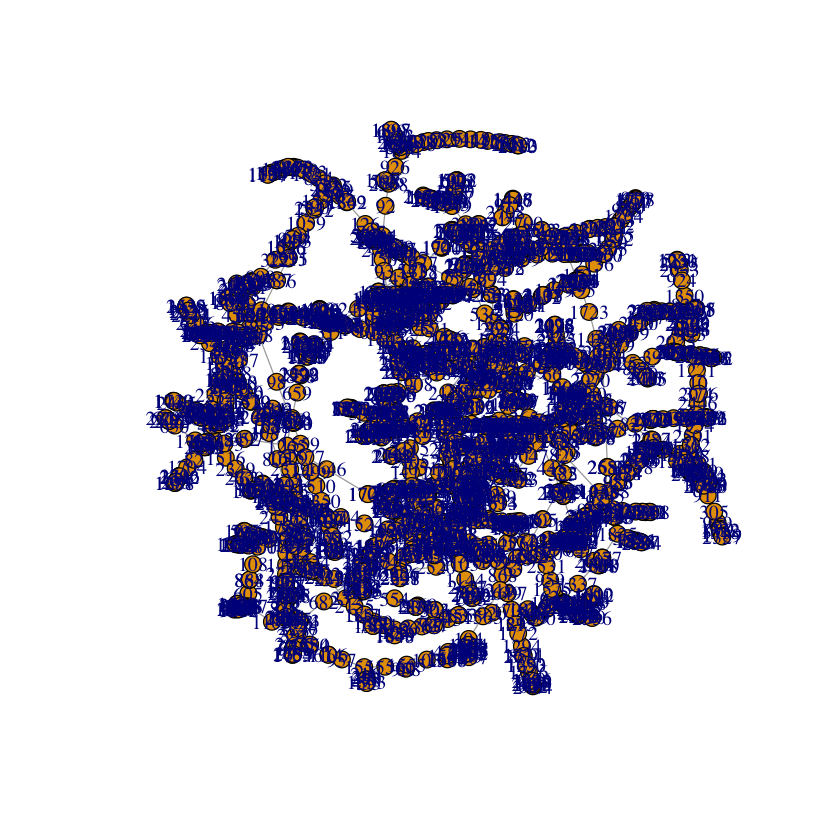

In [4]:
build_travel_graph <- function(csv_f_name, json_f_name) {
    
    edge_data <- read.csv(file=csv_f_name, header=TRUE, sep=",")
    edge_data <- as.data.table(edge_data)

    # clean1: only keep December
    edge_data <- edge_data[month == 12] 

    # Select necessary columns
    edge_data <- edge_data[, c("sourceid", "dstid", "mean_travel_time")]
    setnames(edge_data,"mean_travel_time", "weight")

    # generate graph from edge list, with edge weight
    g <- graph.data.frame(d = edge_data, directed = FALSE)


    # add additional node attr

    json_data <- fromJSON(file=json_f_name)

    # get id_list, addr_list, loc_x_list, loc_y_list
    id_list <- c(1:length(json_data$features))
    id_list <- as.character(id_list)
    addr_list <- c()
    loc_x_list <- c()
    loc_y_list <- c()
    for (i in 1:length(json_data$features)){
        token <- json_data$features[[i]]
        addr = token$properties$DISPLAY_NAME
        x = mean(split(unlist(token$geometry$coordinates),1:2)[[1]])
        y = mean(split(unlist(token$geometry$coordinates),1:2)[[2]])
        addr_list <- c(addr_list, addr)
        loc_x_list <- c(loc_x_list, x)
        loc_y_list <- c(loc_y_list, y)
    }


    # assign node attr street_addr from map: id -> street_addr
    id_street_addr_map = as.list(setNames(addr_list, id_list))
    V(g)$street_addr <- id_street_addr_map[V(g)$name]

    # assign node attr loc_x from map: id -> loc_x
    id_loc_x_map = as.list(setNames(loc_x_list, id_list))
    V(g)$loc_x <- id_loc_x_map[V(g)$name]

    # assign node attr loc_y from map: id -> loc_y
    id_loc_y_map = as.list(setNames(loc_y_list, id_list))
    V(g)$loc_y <- id_loc_y_map[V(g)$name]
    
    # remove duplicates
    g <- simplify(g, remove.multiple = TRUE, edge.attr.comb="mean")
    
    # only keep the giant connected component
    clusters <- components(g)
    gcc_g <- induced.subgraph(g, which(clusters$membership == which.max(clusters$csize)))
    
    return(gcc_g)
}



# read file
# travel_f_name = './dataset/san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv'
csv_f_name = './dataset/san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv'
json_f_name = './dataset/san_francisco_censustracts.json'


g = build_travel_graph(csv_f_name, json_f_name)
# g has 4 node attributes, and 1 edge attribute
# 4 node attributes:
# V(g)$name: id  (str)
# V(g)$street_addr: Street Address  (str) 
# V(g)$loc_x: x of its mean location  (float)
# V(g)$loc_y: y of its mean location  (float)

# 1 edge attribute:
# E(g)$weight: weight of edge, "mean traveling times"   (float)


# Q6
print(sprintf("Number of nodes in G: %d", vcount(g)))
print(sprintf("Number of edges in G: %d", ecount(g)))


# Q7
g_mst <- mst(g, weights = E(g)$weight)
sample_num = 5
sample_pairs <- list()
i <- 1
for (i in 1: sample_num){
    edge <- E(g_mst)[i]
    id_pair <- ends(g_mst, edge)
    sample_pairs[[i]] <- c(V(g_mst)[id_pair[1]]$street_addr, 
                           V(g_mst)[id_pair[2]]$street_addr, edge$weight)
}
print('sample_pairs: ')
print(sample_pairs)
plot(g_mst,vertex.size=6)


- Question 8: Determine what percentage of triangles in the graph (sets
of 3 points on the map) satisfy the triangle inequality. You do not need
to inspect all triangles, you can just estimate by random sampling of
1000 triangles.

In [25]:
Is_triangle <- function(g,v1,v2,v3){
    #given graph g, determine whether the triangle with vertices (v1,v2,v3) 
    #satisfies the triangle inequality. return 1 if inequality holds; 0 otherwise
    
    #v1, v2, v3 are the vertex ids, not names
    
    w1=E(g,P=c(v1,v2))$weight
    w2=E(g,P=c(v2,v3))$weight
    w3=E(g,P=c(v3,v1))$weight
#     cat(w1,w2,w3,'\n')
    if (w1+w2>w3 && abs(w1-w2)<w3){
        return(1)
    }
    else {return(0)}
}
Tr=vector()
Tr=append(Tr,as.vector(triangles(g)))
# cat(length(Tr),'\n')
Total_number=length(Tr)/3
# cat(Total_number,'\n')
Random_starting_pos=sample(1:Total_number,1000)
# cat(Random_starting_pos,'\n')
counter=0
for (st in Random_starting_pos){
    pos=st*3-2
    v1=Tr[pos]
    v2=Tr[pos+1]
    v3=Tr[pos+2]
#     cat(v1,v2,v3,'\n')
    if (Is_triangle(g,v1,v2,v3)==1){
        counter=counter+1
    }
}
cat("The percentage of triangles in the graph is: ", counter/10,'%\n')

The percentage of triangles in the graph is:  94.2 %


In [27]:
# g1=read.graph('./dataset/sample_graph.txt',format=c("ncol"),directed=FALSE)
# # plot(g1,vertex.size=6)

# # v1=which(V(g1)$name=='2')
# # v2=which(V(g1)$name=='5')
# # w=E(g1,P=c(v1,v2))$weight
# # cat(v1,v2,w,'\n')

# # cat('id=',V(g1),'\n','name=',V(g1)$name,'\n')
# # T1=triangles(g1)
# # cat(T1)

# # sample(1:10,11,replace=T)
# cat("gg")

gg

- Question 9: Find the empirical performance of the approximate algorithm:

In [67]:


Two_Approximation <- function(g){
    #The algorithm takes graph g as input
    #and outputs the approximation travel tour as a vector
    
    #Build the Minimum Spanning Tree
    MST=mst(g,weights=E(g)$weight)
#     plot(MST,vertex.size=6)
    
    #Creat a multigraph G by using two copies of each edge of T
    T=as_edgelist(MST)
    Total=length(T[,1])
    for (i in 1:Total){
        id1=which(V(MST)$name==T[i,1])
        id2=which(V(MST)$name==T[i,2])
        w=E(MST,c(T[i,1],T[i,2]))$weight
        MST=MST+edges(c(T[i,1],T[i,2]),weight=w)
    }
#     plot(MST,edge.label=E(MST)$weight,vertex.size=6)
    
    #Find the Eulerian path on the augmented MST
    dfs=dfs(MST,root=V(MST)[1],order=TRUE, order.out=TRUE, father=TRUE)
    Tour=dfs$order
    
    
    #Find the embedded tour
#     Tour=unique(path)
    return(Tour)
    
    
}

tour=Two_Approximation(g)
tour=append(tour,tour[1])
# print(V(g)$loc_x)
# write.table(as.vector(tour), file = "tour.txt", sep = "\t",
#             row.names = FALSE)

#Computing the upper bound of the empirical performance
MST=mst(g,weights=E(g)$weight)
Total_travel_time=sum(E(MST)$weight)

start_node=V(g)[tour[1:1880]]
end_node=V(g)[tour[2:1881]]
dist=distances(g,start_node,end_node)

cost=0
for (i in 1:length(start_node)){
    cost=cost+dist[i,i]
}
rho=cost/Total_travel_time


cat("The empirical performance of the approximate algorithm is: ",rho,'\n')

The empirical performance of the approximate algorithm is:  1.569804 
